## Insurance Price Prediction

### Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Load the dataset
df = pd.read_csv(r'C:\Users\fahim\OneDrive\Desktop\projects\insurance-charges-prediction\insurance.csv')


#### Basic information

In [2]:
print("Dataset Shape: ",df.shape)
print("\nData Type:\n",df.dtypes)
print("\nMissing Values:\n",df.isnull().sum())
print("\nSummary Statistics:\n",df.describe())

Dataset Shape:  (1338, 7)

Data Type:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing Values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary Statistics:
                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


#### Visualize distribution of target variable (Charges)

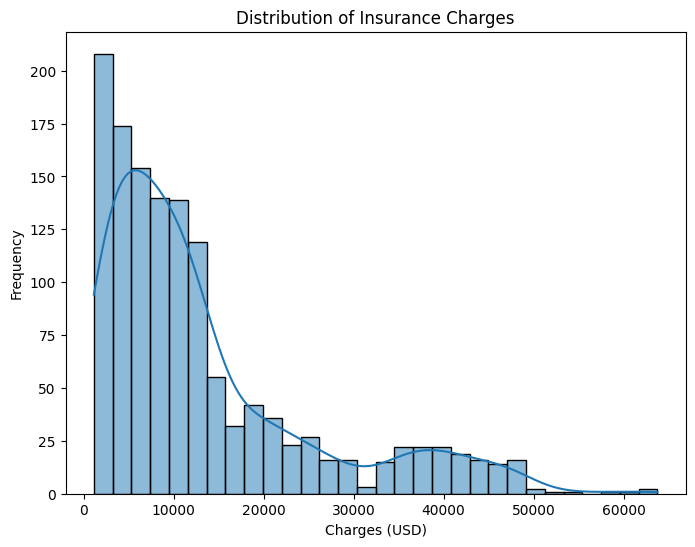

In [3]:
plt.figure(figsize=(8, 6))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges (USD)')
plt.ylabel('Frequency')
plt.show()

###  Visualize relationships

#### Scatter plot: Age vs Charges

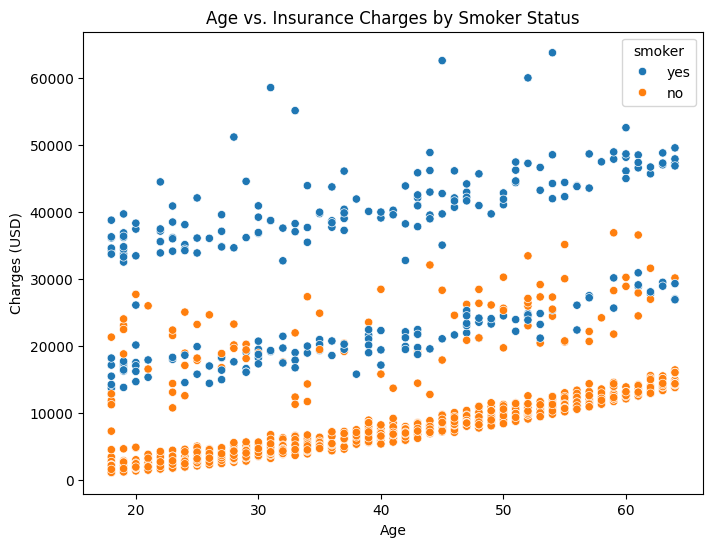

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='charges', hue='smoker', data=df)
plt.title('Age vs. Insurance Charges by Smoker Status')
plt.xlabel('Age')
plt.ylabel('Charges (USD)')
plt.show()

#### Box plot: Smoker vs. Charges

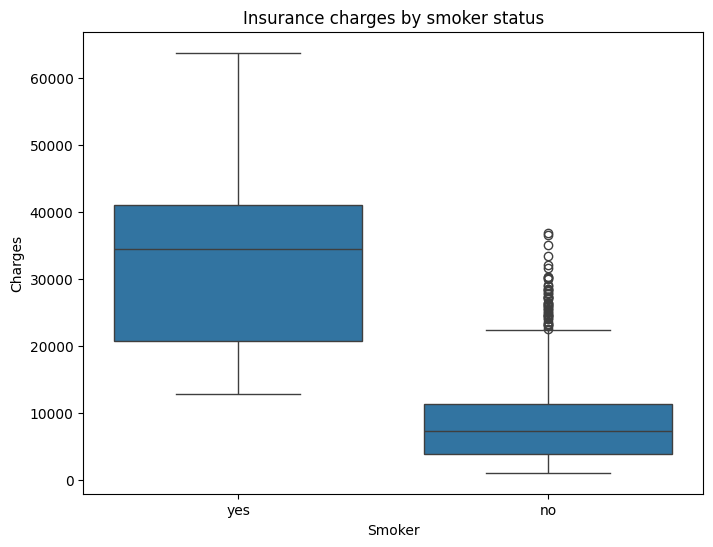

In [5]:
plt.figure(figsize=(8,6))
sns.boxplot(x='smoker',y='charges',data=df)
plt.title('Insurance charges by smoker status')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()

#### Correlation matrix for numerical features

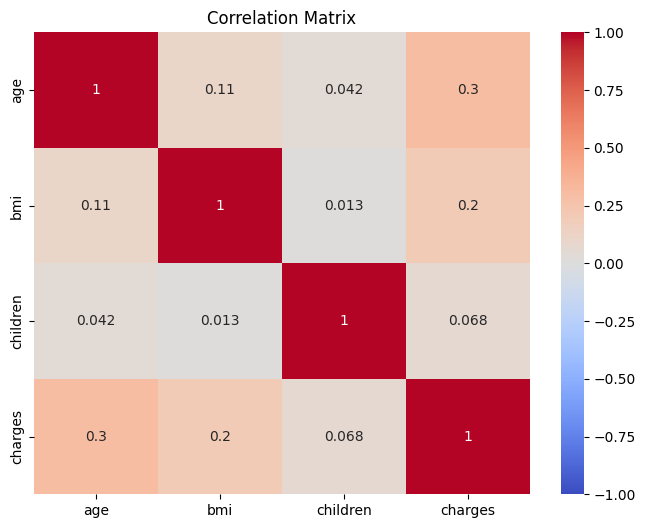

In [6]:
numerical_columns = ['age', 'bmi', 'children','charges']
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_columns].corr(),annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Categorical feature analysis

In [7]:
print("\nRegion Counts:\n", df['region'].value_counts())
print("\nSex Counts:\n", df['sex'].value_counts())


Region Counts:
 region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Sex Counts:
 sex
male      676
female    662
Name: count, dtype: int64


### Data Preprocessing

In [8]:
# importing libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#chekcing for missing values
print("Missing values: \n",df.isnull().sum())

#checking outlier using IQR method
Q1=df['charges'].quantile(0.25)
Q3=df['charges'].quantile(0.75)

IQR=Q3-Q1

lower_bond=Q1-1.5*IQR
upper_bond=Q3+1.5*IQR

outliers=df[(df['charges']<lower_bond) | (df['charges']>upper_bond)]['charges']
print(f"Number of outliers in changes: {len(outliers)}")

Missing values: 
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Number of outliers in changes: 139


In [10]:
# cap outliers
df['charges']=df['charges'].clip(lower=lower_bond,upper=upper_bond)

In [11]:
# encode categorical values
df_encoded=pd.get_dummies(df,columns=['sex','smoker','region'],drop_first=True, dtype=int)


In [12]:
# scale numerical features
scaler=StandardScaler()
numerical_cols=['age', 'bmi', 'children']
df_encoded[numerical_cols]=scaler.fit_transform(df_encoded[numerical_cols])


### Feature Engineering

In [13]:
# Log-transform the target variable (Charges) to reduce skewness
df_encoded['log_charges']=np.log1p(df_encoded['charges'])

# Create interaction features
df_encoded['bmi_smoker']=df_encoded['bmi']*df_encoded['smoker_yes']
df_encoded['age_bmi']=df_encoded['age']* df_encoded['bmi']

# Bin age into groups (e.g., young, middle-aged, senior)
bins = [18, 30, 50, 65]
labels = ['young', 'middle_aged', 'senior']
df_encoded['age_group'] = pd.cut(df_encoded['age'] * scaler.scale_[0] + scaler.mean_[0], 
                                bins=bins, labels=labels, include_lowest=True)
df_encoded = pd.get_dummies(df_encoded, columns=['age_group'], drop_first=True, dtype=int)

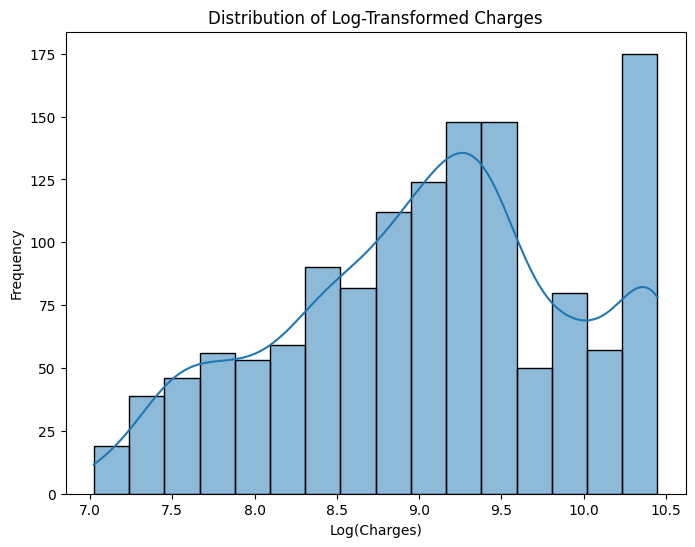

In [14]:
# Visualize transformed target variable
plt.figure(figsize=(8, 6))
sns.histplot(df_encoded['log_charges'], kde=True)
plt.title('Distribution of Log-Transformed Charges')
plt.xlabel('Log(Charges)')
plt.ylabel('Frequency')
plt.show()


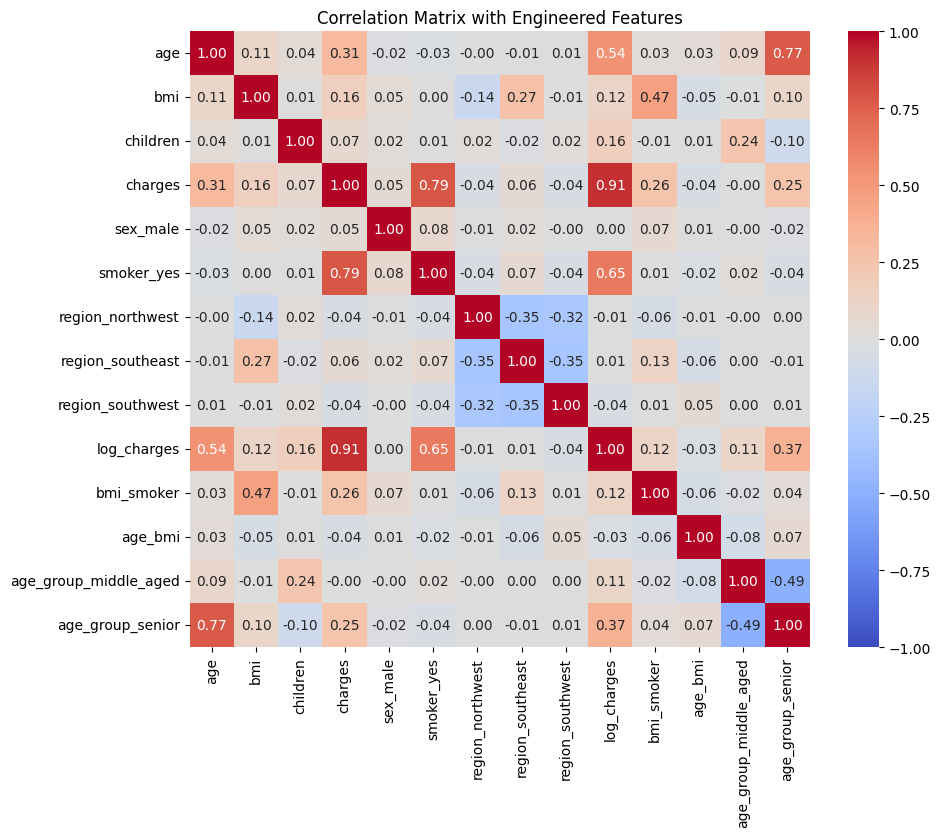

In [15]:
# Correlation matrix for new features
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix with Engineered Features')
plt.show()

In [16]:
# Prepare features (X) and target (y)
# Use log_charges as target for modeling
X = df_encoded.drop(['charges', 'log_charges'], axis=1)
y = df_encoded['log_charges']

In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1070, 12) (1070,)
Testing set shape: (268, 12) (268,)


In [18]:
# # Save preprocessed data (optional, for reference)
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

## Model Training

In [19]:
#import libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Assume X_train, X_test, y_train, y_test are loaded from previous preprocessing
# If not, reload them (uncomment if needed):
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_train = pd.read_csv('y_train.csv')
# y_test = pd.read_csv('y_test.csv')


In [20]:

# Step 7: Model Selection and Training

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100, max_depth=5)
}

# Train models and store predictions
predictions = {}
cv_scores = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    # Perform 5-fold cross-validation (on log_charges)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores[name] = cv_score.mean()
    print(f"{name} - Cross-Validation R²: {cv_score.mean():.4f} (±{cv_score.std():.4f})")

Linear Regression - Cross-Validation R²: 0.7393 (±0.0348)
Random Forest - Cross-Validation R²: 0.7870 (±0.0439)
XGBoost - Cross-Validation R²: 0.7381 (±0.0546)



Model Comparison:
                Model  RMSE (log scale)  MAE (log scale)        R²  \
0  Linear Regression          0.414340         0.264882  0.793988   
1      Random Forest          0.364567         0.186801  0.840510   
2            XGBoost          0.382834         0.210886  0.824126   

    RMSE (USD)    MAE (USD)  
0  7866.697272  3841.989544  
1  4022.485178  1746.969829  
2  4908.308387  2464.798117  


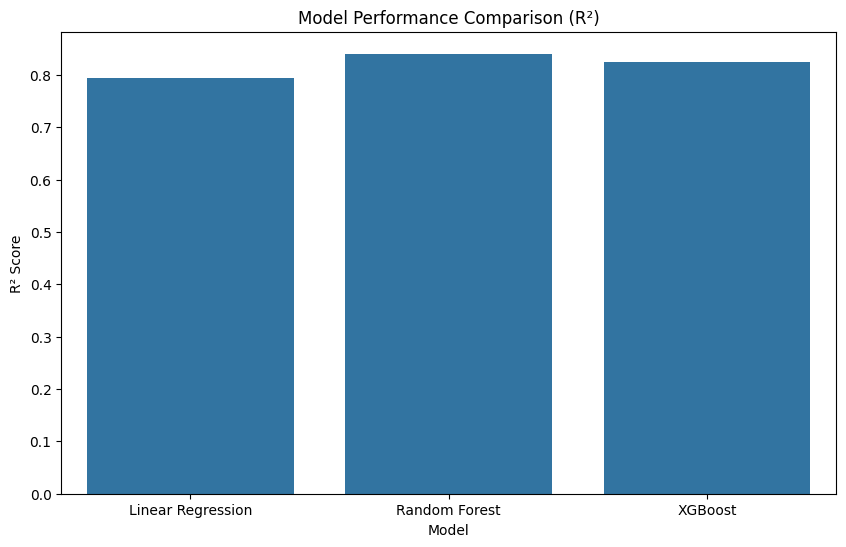

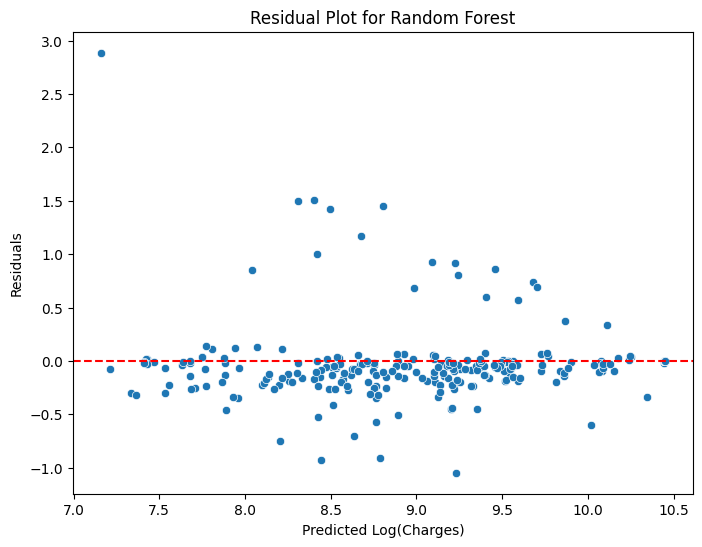

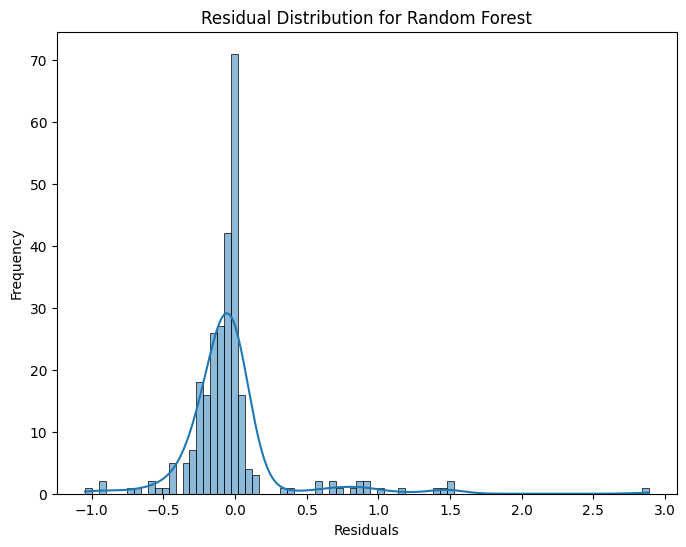

In [21]:
# Step 8: Model Evaluation

# Evaluate models on test set
results = []
for name, y_pred in predictions.items():
    # Calculate metrics (on log_charges)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Convert predictions back to original scale (charges) for interpretability
    y_test_orig = np.expm1(y_test)  # Inverse of log1p
    y_pred_orig = np.expm1(y_pred)
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    
    results.append({
        'Model': name,
        'RMSE (log scale)': rmse,
        'MAE (log scale)': mae,
        'R²': r2,
        'RMSE (USD)': rmse_orig,
        'MAE (USD)': mae_orig
    })

# Create comparison table
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

# Visualize model performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('Model Performance Comparison (R²)')
plt.ylabel('R² Score')
plt.show()

# Residual analysis for the best model (choose based on R²)
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = models[best_model_name]
y_pred_best = predictions[best_model_name]

# Residual plot
residuals = y_test - y_pred_best
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Predicted Log(Charges)')
plt.ylabel('Residuals')
plt.show()

# Distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title(f'Residual Distribution for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

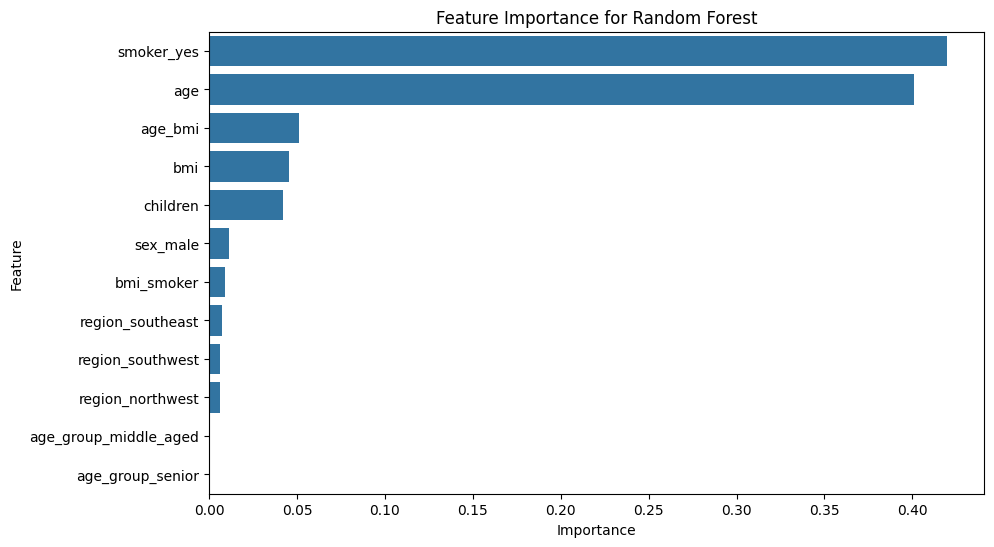


Feature Importance:
                   Feature  Importance
4              smoker_yes    0.419890
0                     age    0.401005
9                 age_bmi    0.051278
1                     bmi    0.045690
2                children    0.041833
3                sex_male    0.011028
8              bmi_smoker    0.008876
6        region_southeast    0.007114
7        region_southwest    0.006376
5        region_northwest    0.006276
10  age_group_middle_aged    0.000544
11       age_group_senior    0.000091

Best Model: Random Forest
Implications: This model can help insurance companies predict medical charges based on patient characteristics, enabling better premium pricing and risk assessment.


In [22]:
# Step 9: Model Interpretation

# Feature importance for tree-based models
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.xlabel('Importance')
    plt.show()
    print("\nFeature Importance:\n", feature_importance)

# Linear Regression coefficients (if best model)
if best_model_name == 'Linear Regression':
    coefs = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': best_model.coef_
    }).sort_values('Coefficient', ascending=False)
    print("\nLinear Regression Coefficients:\n", coefs)

# Practical implications
print(f"\nBest Model: {best_model_name}")
print("Implications: This model can help insurance companies predict medical charges based on patient characteristics, enabling better premium pricing and risk assessment.")

### Save the Model

In [24]:
# Save the Random Forest model and scaler in your Jupyter Notebook
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Assuming 'best_model' is your trained Random Forest and 'scaler' is your StandardScaler
# (from previous scripts)
joblib.dump(best_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']